In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools import get_positive_contributions, compute_entropy, print_equations
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos
from matplotlib.gridspec import GridSpec
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# 设置美观的图形样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体（支持中文）
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示为方块的问题
warnings.filterwarnings('ignore', message='.*U\\+2212.*')

pipline操作流程：

1.生成数据：a 单起始点时间序列；b 多起始点时间序列

可选步骤：时间序列降采样

2.选择合适的library做观测

3.选择合适的optimizer做拟合：a 离散的迭代方程；b 连续的微分方程

4.计算score，多步预测效果看一下

5.提取系数矩阵，进行svd分解，得到奇异值谱和左奇异向量

6.观察奇异值谱截断，计算因果涌现程度，绘制多尺度contribution，计算EC

7.根据奇异向量和谱截断，输出粗粒化函数表达式

8.绘制宏观演化的时间序列，给出宏观动力学方程

可选的分析案例：

1.SIR：原始的SIR动力学；带观测噪音的四维微观数据

2.kuramoto模型

3.洛伦兹动力学

4.耦合Rulkov映射

# 数据生成

In [2]:
def generate_neuron_data(alpha=4.0, sigma=0.0, mu=0.001, beta=0, 
                        T=10000, transients=0, coupling_params=None, x0=None, y0=None, seed=42):
    """
    生成神经元数据，支持单个或多个神经元。
    
    参数:
        alpha: 单个神经元的alpha值，或多个神经元的alpha列表
        sigma: 单个神经元的sigma值，或多个神经元的sigma列表
        mu: 慢变参数
        beta: 常数输入
        x0, y0: 初始条件
        T: 总模拟步数
        transients: 舍弃的暂态步数
        coupling_params: 耦合参数，None表示无耦合
        
    返回:
        dict: 包含所有数据的字典
    """
    # 处理单个/多个神经元的参数
    if isinstance(alpha, (int, float)):
        alpha = [alpha]
    if isinstance(sigma, (int, float)):
        sigma = [sigma]
    
    n_neurons = len(alpha)
    
    # 确保sigma长度与alpha一致
    if len(sigma) != n_neurons:
        sigma = [sigma[0]] * n_neurons
        
    # 设置随机种子
    np.random.seed(seed)
    
    # 初始化状态
    if x0 is None:
        x0 = np.random.uniform(-2, 2)
    if y0 is None:
        y0 = np.random.uniform(-2, 2)
        
    # 初始化数组
    x_series = np.zeros((n_neurons, T))
    y_series = np.zeros((n_neurons, T))
    
    # 设置初始条件
    for i in range(n_neurons):
        x_series[i, 0] = x0
        y_series[i, 0] = y0
    
    # 定义分段函数
    def f(x_val, y_val, a):
        if x_val <= 0:
            return a / (1 - x_val) + y_val
        elif 0 < x_val < a + y_val:
            return a + y_val
        else:
            return -1
    
    # 模拟迭代
    for n in range(T-1):
        for i in range(n_neurons):
            # 计算耦合项（如果有）
            beta_i = beta
            sigma_i = sigma[i]
            
            if coupling_params and n_neurons > 1:
                g = coupling_params.get('g', 0)
                beta_e = coupling_params.get('beta_e', 1.0)
                sigma_e = coupling_params.get('sigma_e', 1.0)
                
                # 计算来自其他神经元的耦合
                coupling_sum_x = 0
                for j in range(n_neurons):
                    if i != j:
                        coupling_sum_x += x_series[j, n] - x_series[i, n]
                
                beta_i = beta +  g *beta_e * coupling_sum_x
                sigma_i = sigma[i] + g * sigma_e * coupling_sum_x
            
            # 更新方程
            x_series[i, n+1] = f(x_series[i, n], y_series[i, n] + beta_i, alpha[i])
            y_series[i, n+1] = y_series[i, n] - mu * (x_series[i, n] + 1) + mu * sigma_i
    
    # 准备参数信息
    params = {
        'alpha': alpha,
        'sigma': sigma,
        'mu': mu,
        'beta': beta,
        '总步数': T,
        '舍弃暂态': transients,
        '有效数据': T - transients,
        '神经元数量': n_neurons
    }
    
    if coupling_params and n_neurons > 1:
        params['耦合参数'] = coupling_params
        params['耦合类型'] = '正耦合' if coupling_params.get('g', 0) > 0 else '负耦合' if coupling_params.get('g', 0) < 0 else '无耦合'
    
    # 准备返回数据
    data = {'params': params}
    
    for i in range(n_neurons):
        data[f'x{i+1}'] = x_series[i, transients:]  # 瞬态后的x序列
        data[f'y{i+1}'] = y_series[i, transients:]  # 瞬态后的y序列
        data[f'x{i+1}_full'] = x_series[i]  # 完整x序列
        data[f'y{i+1}_full'] = y_series[i]  # 完整y序列
    
    data['t'] = np.arange(T - transients)  # 时间索引
    
    return data

In [3]:
def plot_neuron_data(data, title="神经元动态行为", figsize=(18, 10)):
    """
    绘制神经元数据。
    
    参数:
        data: 生成的数据字典
        title: 图标题
        figsize: 图形大小
    """
    params = data['params']
    n_neurons = params['神经元数量']
    
    # 创建图形
    fig = plt.figure(figsize=figsize, facecolor='white')
    gs = GridSpec(2, 3, figure=fig, height_ratios=[1, 1.2], hspace=0.25, wspace=0.3)
    
    # 定义颜色列表
    colors = ['#4C72B0', '#C44E52', '#55A868', '#8172B3', '#FFA15A', '#8C564B']
    
    # 第一行：所有神经元的x随时间变化（长子图，跨3列）
    ax1 = fig.add_subplot(gs[0, :])
    t = data['t']
    
    # 绘制每个神经元的x-t曲线
    for i in range(n_neurons):
        x = data[f'x{i+1}']
        ax1.plot(t, x, color=colors[i % len(colors)], linewidth=0.8, alpha=0.9, label=f'神经元{i+1}')
    
    ax1.set_xlabel('时间（迭代步）', fontsize=12)
    ax1.set_ylabel('快变量 x', fontsize=12)
    ax1.set_title('所有神经元：快变量x随时间变化', fontsize=14, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10, ncol=min(3, n_neurons))
    ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax1.set_facecolor('#F5F5F5')
    
    # 第二行第一列：所有神经元的y随时间变化
    ax2 = fig.add_subplot(gs[1, 0])
    
    # 绘制每个神经元的y-t曲线
    for i in range(n_neurons):
        y = data[f'y{i+1}']
        ax2.plot(t, y, color=colors[i % len(colors)], linewidth=0.8, alpha=0.9, label=f'神经元{i+1}')
    
    ax2.set_xlabel('时间（迭代步）', fontsize=12)
    ax2.set_ylabel('慢变量 y', fontsize=12)
    ax2.set_title('所有神经元：慢变量y随时间变化', fontsize=14, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10, ncol=min(2, n_neurons))
    ax2.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax2.set_facecolor('#F5F5F5')
    
    # 第二行第二列：所有神经元的相平面图
    ax3 = fig.add_subplot(gs[1, 1])
    
    # 绘制每个神经元的相平面图
    for i in range(n_neurons):
        x = data[f'x{i+1}']
        y = data[f'y{i+1}']
        ax3.plot(x, y, color=colors[i % len(colors)], linewidth=0.8, alpha=0.9, label=f'神经元{i+1}')
        # 标记起点和终点
        ax3.scatter(x[0], y[0], color=colors[i % len(colors)], s=30, zorder=5, marker='o', alpha=0.7)
        ax3.scatter(x[-1], y[-1], color=colors[i % len(colors)], s=30, zorder=5, marker='s', alpha=0.7)
    
    ax3.set_xlabel('快变量 x', fontsize=12)
    ax3.set_ylabel('慢变量 y', fontsize=12)
    ax3.set_title('所有神经元：相平面图 (x-y)', fontsize=14, fontweight='bold')
    ax3.legend(loc='best', fontsize=10, ncol=min(2, n_neurons))
    ax3.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
    ax3.set_facecolor('#F5F5F5')
    
    # 第二行第三列：参数信息
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.axis('off')
    
    # 构建参数文本
    param_text = "模型参数\n"
    param_text += "="*25 + "\n"
    
    # 神经元参数
    param_text += f"神经元数量: {n_neurons}\n"
    param_text += "-"*25 + "\n"
    
    for i in range(n_neurons):
        param_text += f"神经元{i+1}:\n"
        param_text += f"  α{i+1} = {params['alpha'][i]}\n"
        param_text += f"  σ{i+1} = {params['sigma'][i]}\n"
        if i < n_neurons - 1:
            param_text += "-"*25 + "\n"
    
    # 通用参数
    param_text += "="*25 + "\n"
    param_text += f"μ = {params['mu']}\n"
    param_text += f"β = {params['beta']}\n"
    param_text += f"总步数: {params['总步数']}\n"
    param_text += f"舍弃暂态: {params['舍弃暂态']}步\n"
    param_text += f"有效数据: {params['有效数据']}步\n"
    
    # 耦合参数（如果有）
    if '耦合参数' in params:
        cp = params['耦合参数']
        param_text += "="*25 + "\n"
        param_text += "耦合参数:\n"
        param_text += f"  耦合强度 g = {cp.get('g', 'N/A')}\n"
        param_text += f"  快耦合系数 β_e = {cp.get('beta_e', 'N/A')}\n"
        param_text += f"  慢耦合系数 σ_e = {cp.get('sigma_e', 'N/A')}\n"
        param_text += f"  耦合类型: {params.get('耦合类型', 'N/A')}\n"
    
    # 计算合适的字体大小
    font_size = max(8, min(10, 10 - n_neurons // 3))
    
    ax4.text(0.05, 0.98, param_text, fontsize=font_size, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='#F0F0F0', 
                     alpha=0.9, edgecolor='#D3D3D3'))
    
    plt.suptitle(f'{title}', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    return fig

In [4]:
coupling_params = {'g': 0.043, 'beta_e': 1.0, 'sigma_e': 1.0 }
alpha=[4.9, 5.0]
sigma=[0.24, 0.245]
mu=0.001
beta=0
T=6000
transients=3000
seed=None

In [5]:
mu = 0.001
beta = 0
T = 6000
transients = 3000
seed=None
coupling_params = {'g': 0.043, 'beta_e': 1.0, 'sigma_e': 1.0 }

alpha_cluster_A = [4.85, 4.9]   
sigma_cluster_A = [0.235, 0.24] 

alpha_cluster_B = [5.1, 5.15]  
sigma_cluster_B = [0.25, 0.255] 

alpha = alpha_cluster_A + alpha_cluster_B  
sigma = sigma_cluster_A + sigma_cluster_B  

In [6]:
# 生成两个耦合神经元数据
data = generate_neuron_data(alpha=alpha,sigma=sigma,mu=mu, beta=beta,T=T,transients=transients, 
                            coupling_params=coupling_params,seed=seed)

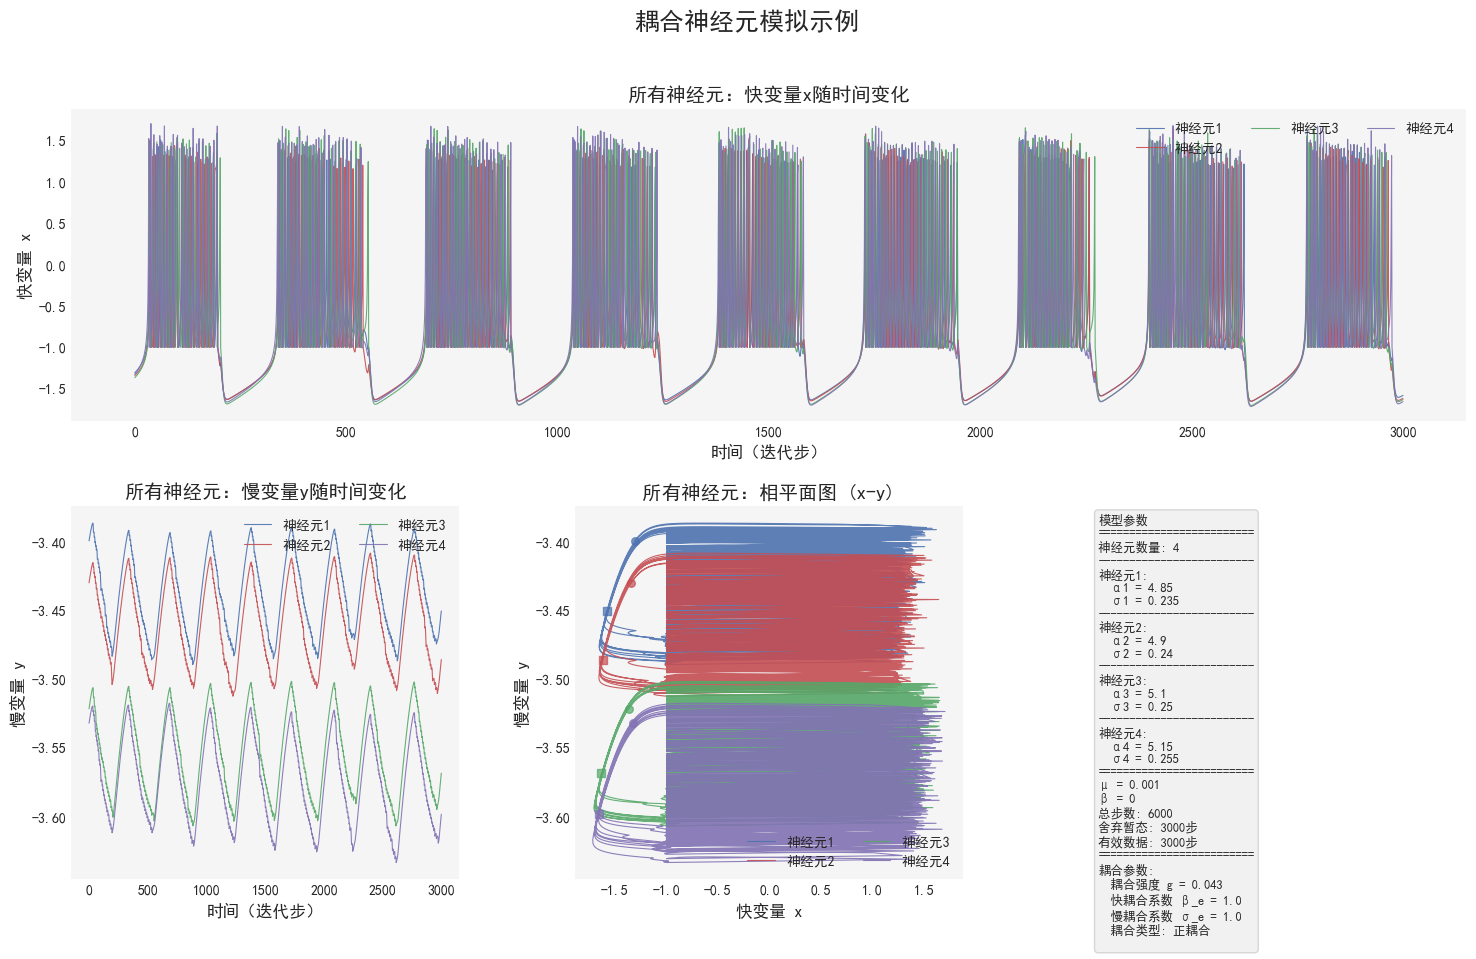

In [7]:
fig = plot_neuron_data(data, title="耦合神经元模拟示例")

In [8]:
data['x1'].shape

(3000,)

In [9]:
x_data = np.column_stack([data['x1'], data['y1'], data['x2'], data['y2'],data['x3'], data['y3'], data['x4'], data['y4']])
t_list = data['t']

In [10]:
x_data.shape

(3000, 8)

In [11]:
data['t'].shape

(3000,)

# 选择library

In [12]:
# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=1,include_bias=True)
library_functions = [
    lambda x: x,
    lambda x: np.sin(x),
    lambda x: np.cos(x),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ide

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names()

# 单时间序列
print(x_data.shape)
print(x_data_lift.shape)
# 多时间序列
#print(x_data_lift[0].shape)
# 检查观测函数变量名
print(names)

(3000, 8)
(3000, 8)
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']


# 进行拟合

In [13]:
# 离散的迭代方程 or 连续的微分方程
#discrete_time=False
discrete_time=True
dt = 1
# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.2, regularizer="l1")
lasso_optimizer = Lasso(alpha=0.01, max_iter=2000, fit_intercept=False)

optimizer = lasso_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=names)
model.print()

(x0)[k+1] = 0.455 x0[k] + 0.040 x1[k] + 0.147 x2[k] + 0.108 x4[k] + 0.001 x5[k] + 0.100 x6[k]
(x1)[k+1] = 0.999 x1[k]
(x2)[k+1] = 0.130 x0[k] + 0.036 x1[k] + 0.466 x2[k] + 0.002 x3[k] + 0.108 x4[k] + 0.001 x5[k] + 0.113 x6[k]
(x3)[k+1] = 1.005 x1[k]
(x4)[k+1] = 0.295 x0[k] + 0.083 x2[k] + 0.393 x4[k] + 0.023 x5[k] + 0.108 x6[k]
(x5)[k+1] = 1.033 x1[k]
(x6)[k+1] = 0.106 x0[k] + 0.222 x2[k] + 0.182 x4[k] + 0.011 x5[k] + 0.380 x6[k] + 0.008 x7[k]
(x7)[k+1] = 1.038 x1[k]


In [14]:
# 计算score
model.score(x_data_lift, t=dt)

0.7174045839761726

# 多步预测

In [15]:
# 单时间序列
init_data = x_data_lift[0,:]
# 多时间序列
#init_data = x_data_lift[0][0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,len(t_list)-1)
else:
    X_data_predicted = model.simulate(init_data,t_list) 

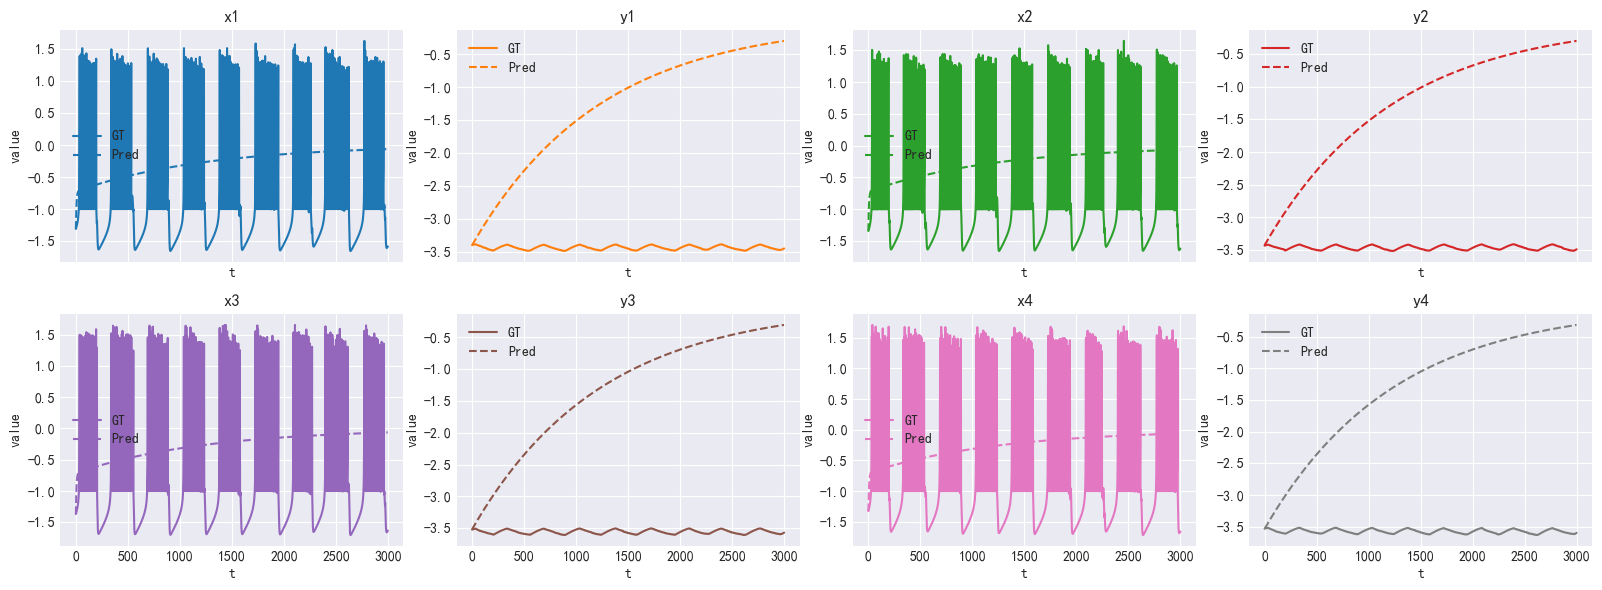

In [16]:
# 8 个通道的名字
channels = ['x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']

# 选一个颜色循环（8 种颜色）
colors = plt.cm.tab10.colors[:8]

fig, axes = plt.subplots(2, 4, figsize=(16, 6), sharex=True, sharey=False)
axes = axes.flatten()

for i, (ax, name, c) in enumerate(zip(axes, channels, colors)):
    # 画真实值（实线）
    ax.plot(x_data_lift[:, i],  ls='-',  c=c, label='GT')
    # 画预测值（虚线）
    ax.plot(X_data_predicted[:, i], ls='--', c=c, label='Pred')
    
    ax.set_title(name)
    ax.set_xlabel('t')
    ax.set_ylabel('value')
    ax.legend()

plt.tight_layout()
plt.show()

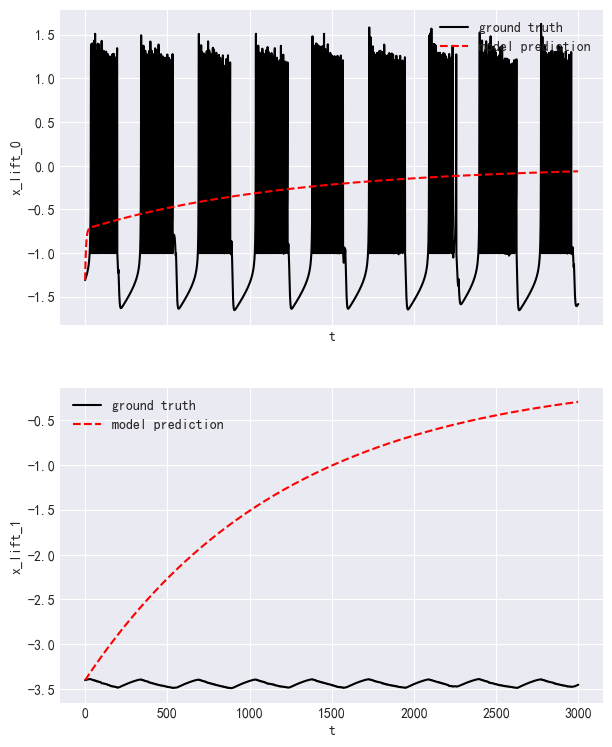

In [17]:
# 只看部分维度的多步预测
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(7, 9))
for i in range(2):
    axs[i].plot(x_data_lift[:, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

# svd分解

(8, 8)


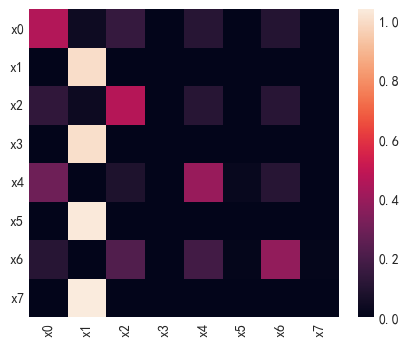

In [18]:
# 提取和处理系数矩阵
A = model.coefficients()
print(A.shape)
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(5, 4)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

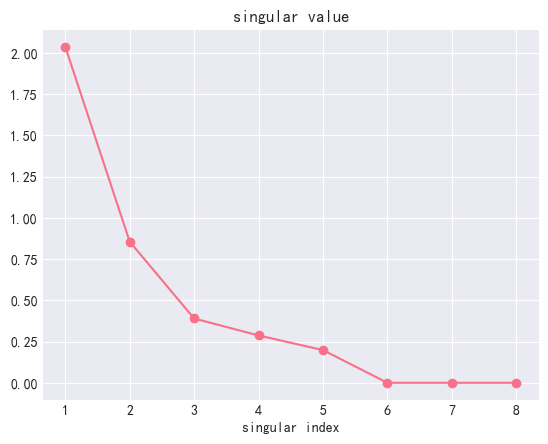

[2.03813481e+00 8.56149476e-01 3.90045903e-01 2.87071085e-01
 1.98403683e-01 2.36890601e-05 1.67030760e-05 4.72779689e-08]


In [19]:
# SVD
U,S,V = np.linalg.svd(A)
plt.figure()
plt.plot(range(1,len(S)+1), S, marker='o')
plt.grid(True)
plt.xlabel('singular index')
plt.title('singular value')
plt.show()
print(S)

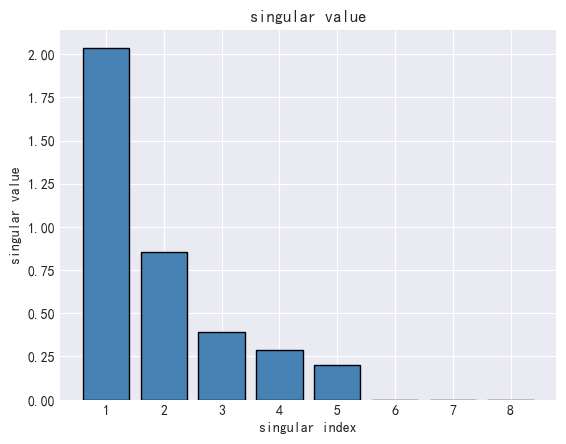

In [20]:
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')          # 只留横网格，看起来更干净
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

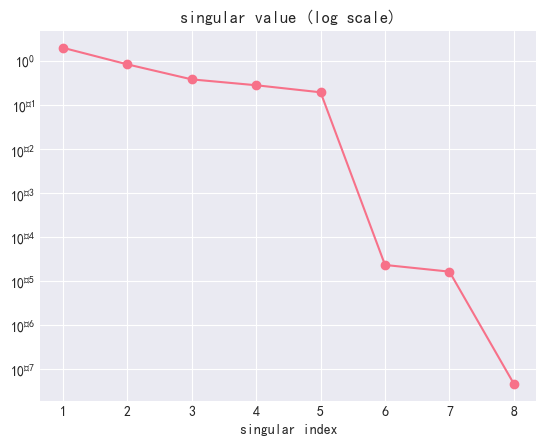

In [21]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体（支持中文）
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示为方块的问题
warnings.filterwarnings('ignore', message='.*U\\+2212.*')
plt.figure()
plt.semilogy(range(1, len(S)+1), S, marker='o')   # 关键：semilogy
plt.grid(True)
plt.xlabel('singular index')
plt.title('singular value (log scale)')
plt.show()

In [22]:
# 选取截断
rank = 2
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

0.9759114702955889


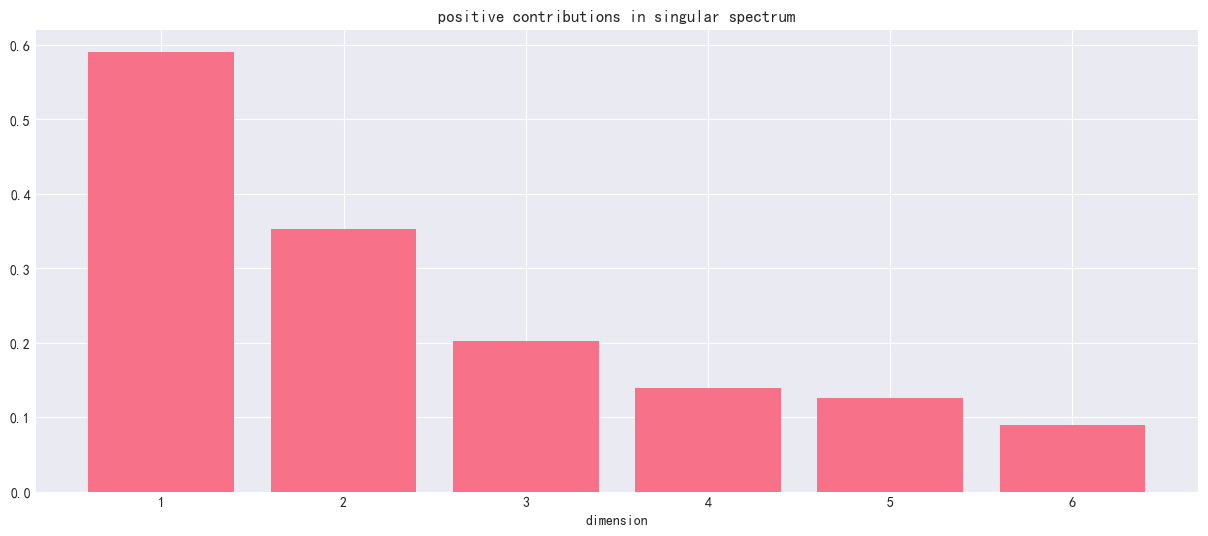

In [23]:
# 多尺度因果力分布
diff = get_positive_contributions(S)
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [24]:
# 计算EC
print(compute_entropy(diff))

2.270693043203409


# 输出粗粒化表达式

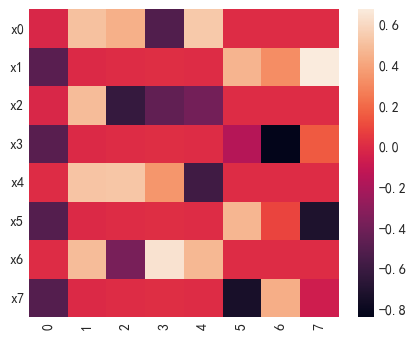

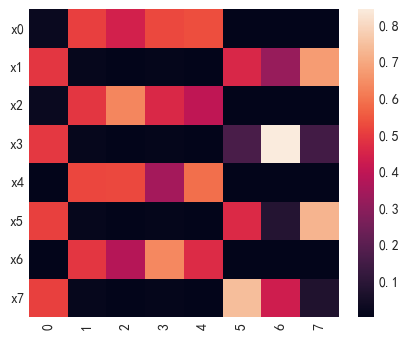

In [25]:
# 绘制奇异向量
U_abs = np.abs(U)

plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

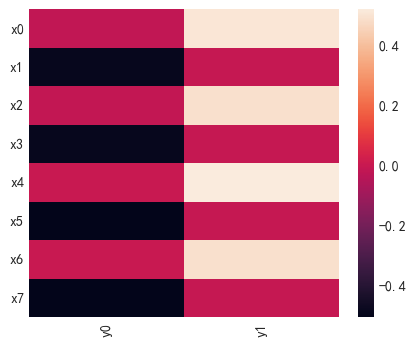

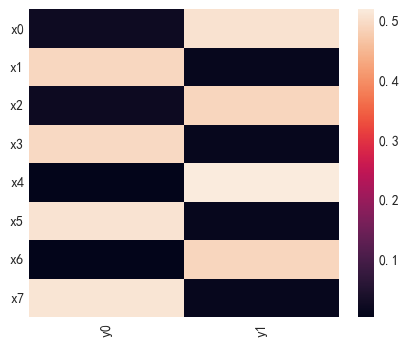

In [26]:
# 粗粒化函数系数
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(5, 4)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [27]:
# 输出粗粒化函数表达式
print_equations(coarse_grain_coff, names, macro_name)

y0 = -0.0217 * x0 - 0.4899 * x1 - 0.0198 * x2 - 0.4931 * x3 - 0.0019 * x4 - 0.5066 * x5 - 0.0018 * x6 - 0.5092 * x7
------------------------------
y1 = 0.5051 * x0 - 0.0110 * x1 + 0.4878 * x2 - 0.0111 * x3 + 0.5178 * x4 - 0.0114 * x5 + 0.4882 * x6 - 0.0114 * x7
------------------------------


# 描述宏观演化

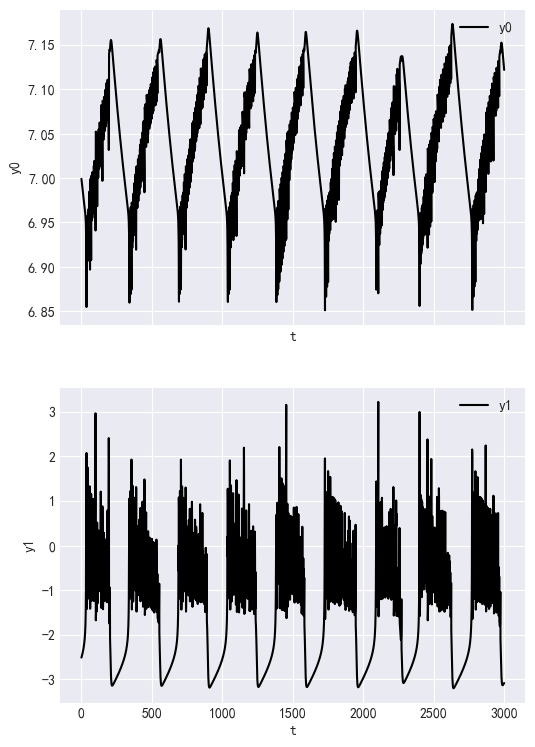

In [28]:
macro_data = x_data_lift @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

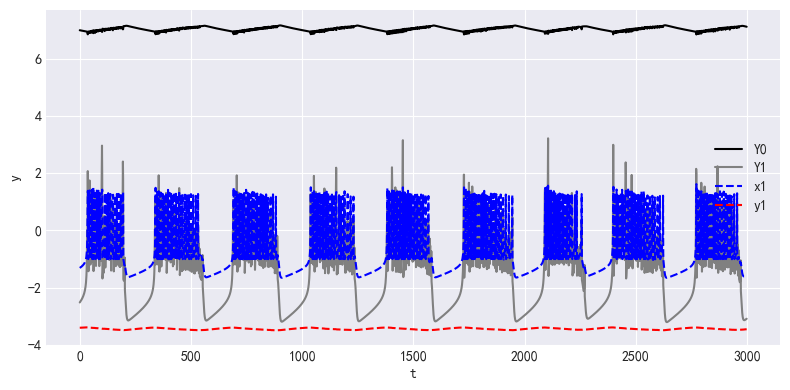

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(macro_data[:,0], color='k', label='Y0')  
ax.plot(macro_data[:,1], color='grey', label='Y1')  
ax.plot(x_data[:,0], '--',color='blue', label='x1')
ax.plot(x_data[:,1], '--',color='red', label='y1')
ax.legend()
ax.set(xlabel='t', ylabel='y')
fig.tight_layout()
plt.show()

In [30]:
# 给出宏观动力学方程
A_macro = coarse_grain_coff.T @ A @ coarse_grain_coff
macro_name_k = [i+'[k]' for i in macro_name]
macro_name_next = [i+'[k+1]' for i in macro_name]
print_equations(A_macro, macro_name_k, macro_name_next)

y0[k+1] = 0.9998 * y0[k] - 0.0294 * y1[k]
------------------------------
y1[k+1] = 0.0040 * y0[k] + 0.8483 * y1[k]
------------------------------
